In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model

#np.random.seed(437) 

## Homomorphic Encryption

In [2]:
def homomorphic_encryption_train(X,y):
    # U1 is an orthogonal matrix
    U1 = ortho_group.rvs(dim=X.shape[0])
    
    # U2 is an invertible matrix
    if X.shape[1] > 1:
        U2 = ortho_group.rvs(dim=X.shape[1])
    else:
        U2 = np.random.rand(1,1)
    
    X_enc = U1.dot(X).dot(U2)
    y_enc = U1.dot(y)
    
    return [X_enc,y_enc,U1,U2]

In [3]:
def homomorphic_decryption_train(X,y,U1,U2):
    
    X_dec = U1.T.dot(X).dot(np.linalg.inv(U2))
    y_dec = U1.T.dot(y)
    
    return [X_dec,y_dec]

In [4]:
def homomorphic_encryption_test(X,U2):

    # U3 is an invertible matrix
    if X.shape[0] > 1:
        U3 = ortho_group.rvs(dim=X.shape[0])
    else:
        U3 = np.random.rand(1,1)
    #from IPython import embed; embed()
    X_enc = U3.dot(X).dot(np.linalg.inv(U2))
    
    return [X_enc,U3]

In [5]:
def homomorphic_decryption_test(y_enc,U3):
    
    y_dec = np.linalg.inv(U3).T.dot(y)
    
    return y_dec

## Generate Data

In [6]:
# m number of data points
# n number of features
m = 100
n = 1

In [7]:
def generate_1d_dataset(m, n, factor=2.0):
    X = np.matrix(np.expand_dims(np.arange(m), 1))
    y = X + np.random.random((m, n)) * factor

    return train_test_split(X, y, test_size=0.5, random_state=42)

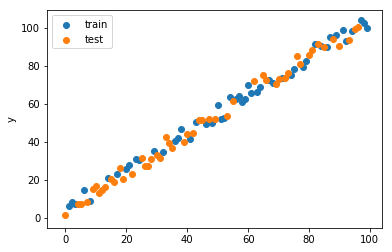

In [8]:
X_train, X_test, y_train, y_test = generate_1d_dataset(m, n, factor=10.0)
#X_train = np.array([[1,xi.item()] for xi in X_train])
#X_test = np.array([[1,xi.item()] for xi in X_test])
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="train")
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Test the Encryption/Decryption Method

In [9]:
H_enc = homomorphic_encryption_train(X_train,y_train)

In [10]:
H_dec = homomorphic_decryption_train(H_enc[0],H_enc[1],H_enc[2],H_enc[3])

In [11]:
abs(sum(H_dec[0] - X_train))

matrix([[5.71986902e-13]])

In [12]:
abs(sum(H_dec[1] - y_train))

matrix([[6.6346928e-13]])

In [13]:
X_enc = H_enc[0]
y_enc = H_enc[1]

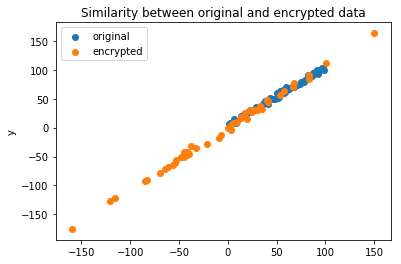

In [14]:
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="original")
plt.scatter(X_enc.T.tolist()[0], y_enc.T.tolist()[0], label="encrypted")
plt.title("Similarity between original and encrypted data")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Train Linear Regression

In [15]:
def estimator_OLS(X,y):
    X = np.array([[1,xi.item()] for xi in X])
    β̂ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return β̂

### Raw DATA

In [16]:
# Homemade estimator
β̂_raw = estimator_OLS(X_train,y_train)
β̂_raw

matrix([[5.56981782],
        [0.98769755]])

In [17]:
# sklearn estimator
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

print(regr.intercept_[0])
regr.coef_[0][0]

5.569817820271503


0.987697547643952

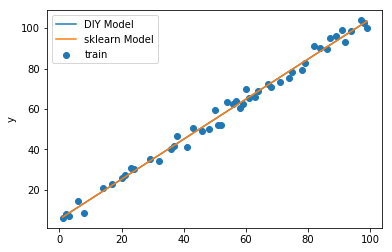

In [18]:
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="train")
plt.plot([np.min(X_train), np.max(X_train)], [np.min(X_train)*β̂_raw[1].item() + β̂_raw[0].item(), np.max(X_train)*β̂_raw[1].item() + β̂_raw[0].item()], label="DIY Model")
plt.plot([np.min(X_train), np.max(X_train)], [np.min(X_train)*regr.coef_[0][0] + regr.intercept_[0], np.max(X_train)*regr.coef_[0][0] + regr.intercept_[0]], label="sklearn Model")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### Encrypted DATA

In [19]:
# Homemade estimator
β̂_enc = estimator_OLS(X_enc,y_enc)
β̂_enc

matrix([[-0.27238384],
        [ 1.08171624]])

In [20]:
# sklearn estimator
regr_enc = linear_model.LinearRegression(fit_intercept=True)
regr_enc.fit(X_enc, y_enc)

print(regr_enc.intercept_[0])
regr_enc.coef_[0][0]

-0.27238384343735245


1.0817162436757943

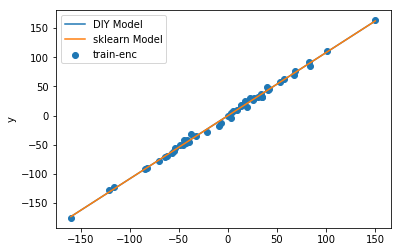

In [21]:
plt.scatter(X_enc.T.tolist()[0], y_enc.T[0], label="train-enc")
plt.plot([np.min(X_enc), np.max(X_enc)], [np.min(X_enc)*β̂_enc[1].item() + β̂_enc[0].item(), np.max(X_enc)*β̂_enc[1].item() + β̂_enc[0].item()], label="DIY Model")
plt.plot([np.min(X_enc), np.max(X_enc)], [np.min(X_enc)*regr_enc.coef_[0][0] + regr_enc.intercept_[0], np.max(X_enc)*regr_enc.coef_[0][0] + regr_enc.intercept_[0]], label="sklearn Model")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Prediction

In [22]:
def predict(β̂,X):
    X = np.array([[1,xi.item()] for xi in X])
    return X.dot(β̂)

### Prediction on Encrypted DATA

In [23]:
H = homomorphic_encryption_test(X_test,H_enc[3])

y_pred_homo = predict(β̂_enc,H[0])
print(f"R2: {r2_score(y_test, y_pred_homo,multioutput='uniform_average')}")

R2: -7.343997648444965


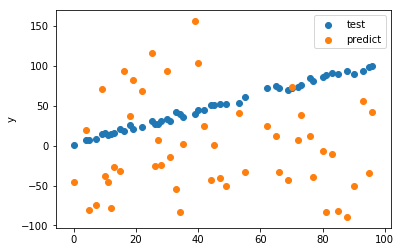

In [24]:
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.scatter(X_test.T.tolist()[0], y_pred_homo.T.tolist()[0], label="predict")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### Decryption After Prediction

In [25]:
y_pred_homo_dec = np.linalg.inv(H[1]).dot(y_pred_homo)
print(f"R2: {r2_score(y_test, y_pred_homo_dec,multioutput='uniform_average')}")

R2: 0.985689534363202


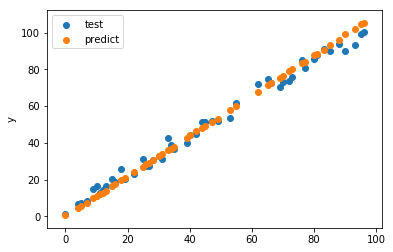

In [26]:
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.scatter(X_test.T.tolist()[0], y_pred_homo_dec.T.tolist()[0], label="predict")
plt.ylabel("X") 
plt.ylabel("y")
plt.legend()
plt.show()